In [1]:
!pip install fredapi

## 1. 데이터 수집

* 069500.KS: KODEX 200 - KOSPI 200 지수 추종
* 232080.KS: Tiger KOSDAQ 150 ETF
* 143850.KS: TIGER S&P500 Futures ETF
* 195930.KS: Tiger Synth-Euro Stocks 50 ETF H
* 238720.ks: KINDEX Japan Nikkei225 ETF(H)
* 192090.KS: TIGER ChinaA300 ETF
* 148070.KS: KOSEF 10년 국채 - 한국 10년 국채 투자
* 136340.KS: KBSTAR KRX300 - 중기우량회사
* 182490.KS: TIGER 미국 채권 - TIGER 단기선진하이일드(합성H)
* 132030.KS: KODEX 골드 선물 - 금 선물 추종
* 130680.KS: TIGER WTI 원유 - WTI 원유 선물 추종
* 114800.KS: KODEX 인버스 - KOSPI 200 지수와 반대로 움직임
* 138230.KS: KOSEF 미국달러선물
* 139660.KS: KOSEF 미국달러선물인버스





In [2]:
import yfinance as yf
import pandas as pd
from fredapi import Fred
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# FRED API 키 설정
fred_api_key = '45cf71e3666ba3e38267b6477d920a60'
fred = Fred(api_key=fred_api_key)

# 티커 데이터 수집
tickers = ['069500.KS', '232080.KS', '143850.KS', '195930.KS', '238720.KS', '192090.KS',
            '148070.KS', '136340.KS', '182490.KS', '132030.KS', '130680.KS','114800.KS','138230.KS','139660.KS']
etf = yf.Tickers(tickers)
etf_data = etf.history(start='2017-01-01', actions=False)['Close'].resample('D').last()

# 거시경제적 지표 수집
gdp = fred.get_series('GDP', start='2017-01-01').resample('D').ffill()
unemployment = fred.get_series('UNRATE', start='2017-01-01').resample('D').ffill()
inflation = fred.get_series('CPIAUCSL', start='2017-01-01').resample('D').ffill()  # 소비자물가지수
interest_rate = fred.get_series('FEDFUNDS', start='2017-01-01').resample('D').ffill()
exchange_rate = fred.get_series('DEXKOUS', start='2017-01-01').resample('D').ffill()
consumer_sentiment = fred.get_series('UMCSENT', start='2017-01-01').resample('D').ffill()  # 소비자동향지수

dxy = yf.download('DX-Y.NYB', start='2017-01-01')['Close'].resample('D').ffill()  # 달러 인덱스
oil = yf.download('CL=F', start='2017-01-01')['Close'].resample('D').ffill()  # WTI 석유 가격
gold = yf.download('GC=F', start='2017-01-01')['Close'].resample('D').ffill()  # 금 가격

# 데이터 병합
macro_data = pd.concat([gdp, unemployment, inflation, interest_rate, exchange_rate, consumer_sentiment, dxy, oil, gold], axis=1)
macro_data.columns = ['GDP', 'Unemployment', 'Inflation', 'Interest_Rate', 'Exchange_Rate', 'Consumer_Sentiment', 'Dollar_Index', 'Oil_Price', 'Gold_Price']

# 결측값 처리
macro_data.fillna(method='ffill', inplace=True)
macro_data.fillna(method='bfill', inplace=True)

# 데이터 합치기
data = pd.concat([etf_data, macro_data], axis=1).dropna()

print(data.tail())  # 데이터 확인


[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            069500.KS  114800.KS  130680.KS  132030.KS  136340.KS  138230.KS  \
2024-07-02    38345.0     4040.0     4800.0    14430.0   105500.0    15175.0   
2024-07-03    38505.0     4025.0     4790.0    14465.0   105520.0    15190.0   
2024-07-04    39020.0     3970.0     4805.0    14585.0   105630.0    15095.0   
2024-07-05    39740.0     3890.0     4840.0    14640.0   105645.0    15085.0   
2024-07-08    39610.0     3910.0     4780.0    14750.0   105680.0    15135.0   

            139660.KS  143850.KS  148070.KS  182490.KS  ...  238720.KS  \
2024-07-02     8515.0    60285.0   113450.0    12715.0  ...    28285.0   
2024-07-03     8495.0    60680.0   113675.0    12820.0  ...    28655.0   
2024-07-04     8545.0    61010.0   114030.0    12745.0  ...    28885.0   
2024-07-05     8570.0    61070.0   114020.0    12750.0  ...    28820.0   
2024-07-08     8555.0    61275.0   114285.0    12770.0  ...    28895.0   

                  GDP  Unemployment  Inflation  Interest_Rate  Exchange_Ra

### feature importance 확인하기

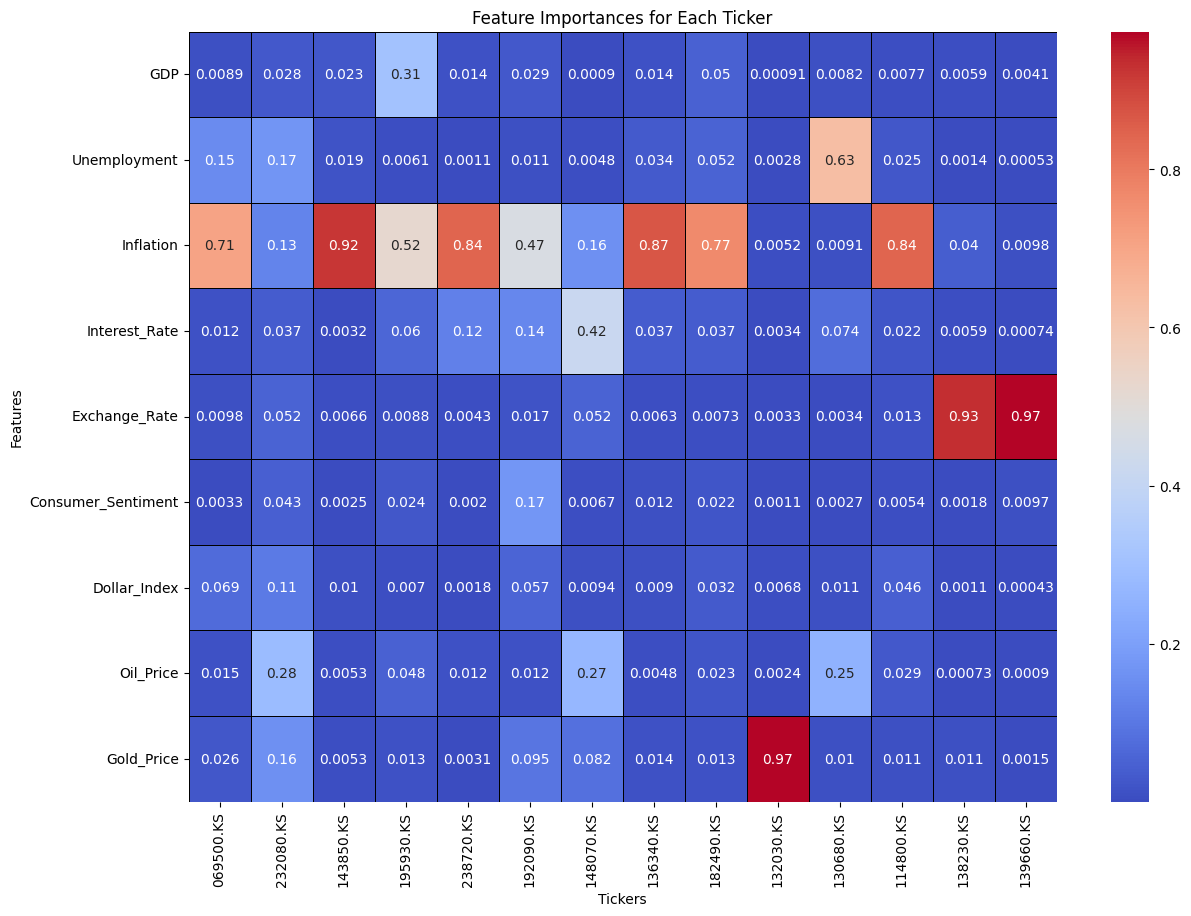

                    069500.KS  232080.KS  143850.KS  195930.KS  238720.KS  \
GDP                  0.008915   0.027708   0.023326   0.308219   0.013905   
Unemployment         0.147879   0.167838   0.019225   0.006103   0.001135   
Inflation            0.707496   0.126609   0.924270   0.524698   0.841503   
Interest_Rate        0.011932   0.036548   0.003231   0.060189   0.120200   
Exchange_Rate        0.009810   0.051507   0.006632   0.008757   0.004329   
Consumer_Sentiment   0.003307   0.042946   0.002485   0.024143   0.002032   
Dollar_Index         0.069122   0.105820   0.010228   0.006967   0.001824   
Oil_Price            0.015173   0.284074   0.005268   0.048338   0.011931   
Gold_Price           0.026366   0.156950   0.005335   0.012588   0.003142   

                    192090.KS  148070.KS  136340.KS  182490.KS  132030.KS  \
GDP                  0.028558   0.000896   0.013984   0.049635   0.000908   
Unemployment         0.010522   0.004834   0.033677   0.051508   0.002752  

In [3]:
import seaborn as sns

# Normalize macroeconomic indicators
scaler = StandardScaler()
macro_data_scaled = pd.DataFrame(scaler.fit_transform(macro_data), index=macro_data.index, columns=macro_data.columns)

# Prepare feature importance extraction
feature_importances = {}

# Loop through each ticker and compute feature importances
for ticker in tickers:
    ticker_data = data[[ticker]].dropna()
    merged_data = pd.concat([ticker_data, macro_data_scaled], axis=1).dropna()

    X = merged_data.drop(columns=[ticker])
    y = merged_data[ticker]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    importances = model.feature_importances_
    feature_importances[ticker] = importances

# Display feature importance as a heatmap
importance_df = pd.DataFrame(feature_importances, index=macro_data.columns)
plt.figure(figsize=(14, 10))
sns.heatmap(importance_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Feature Importances for Each Ticker')
plt.xlabel('Tickers')
plt.ylabel('Features')
plt.show()

# Print the feature importances
print(importance_df)

### 시계열 분석

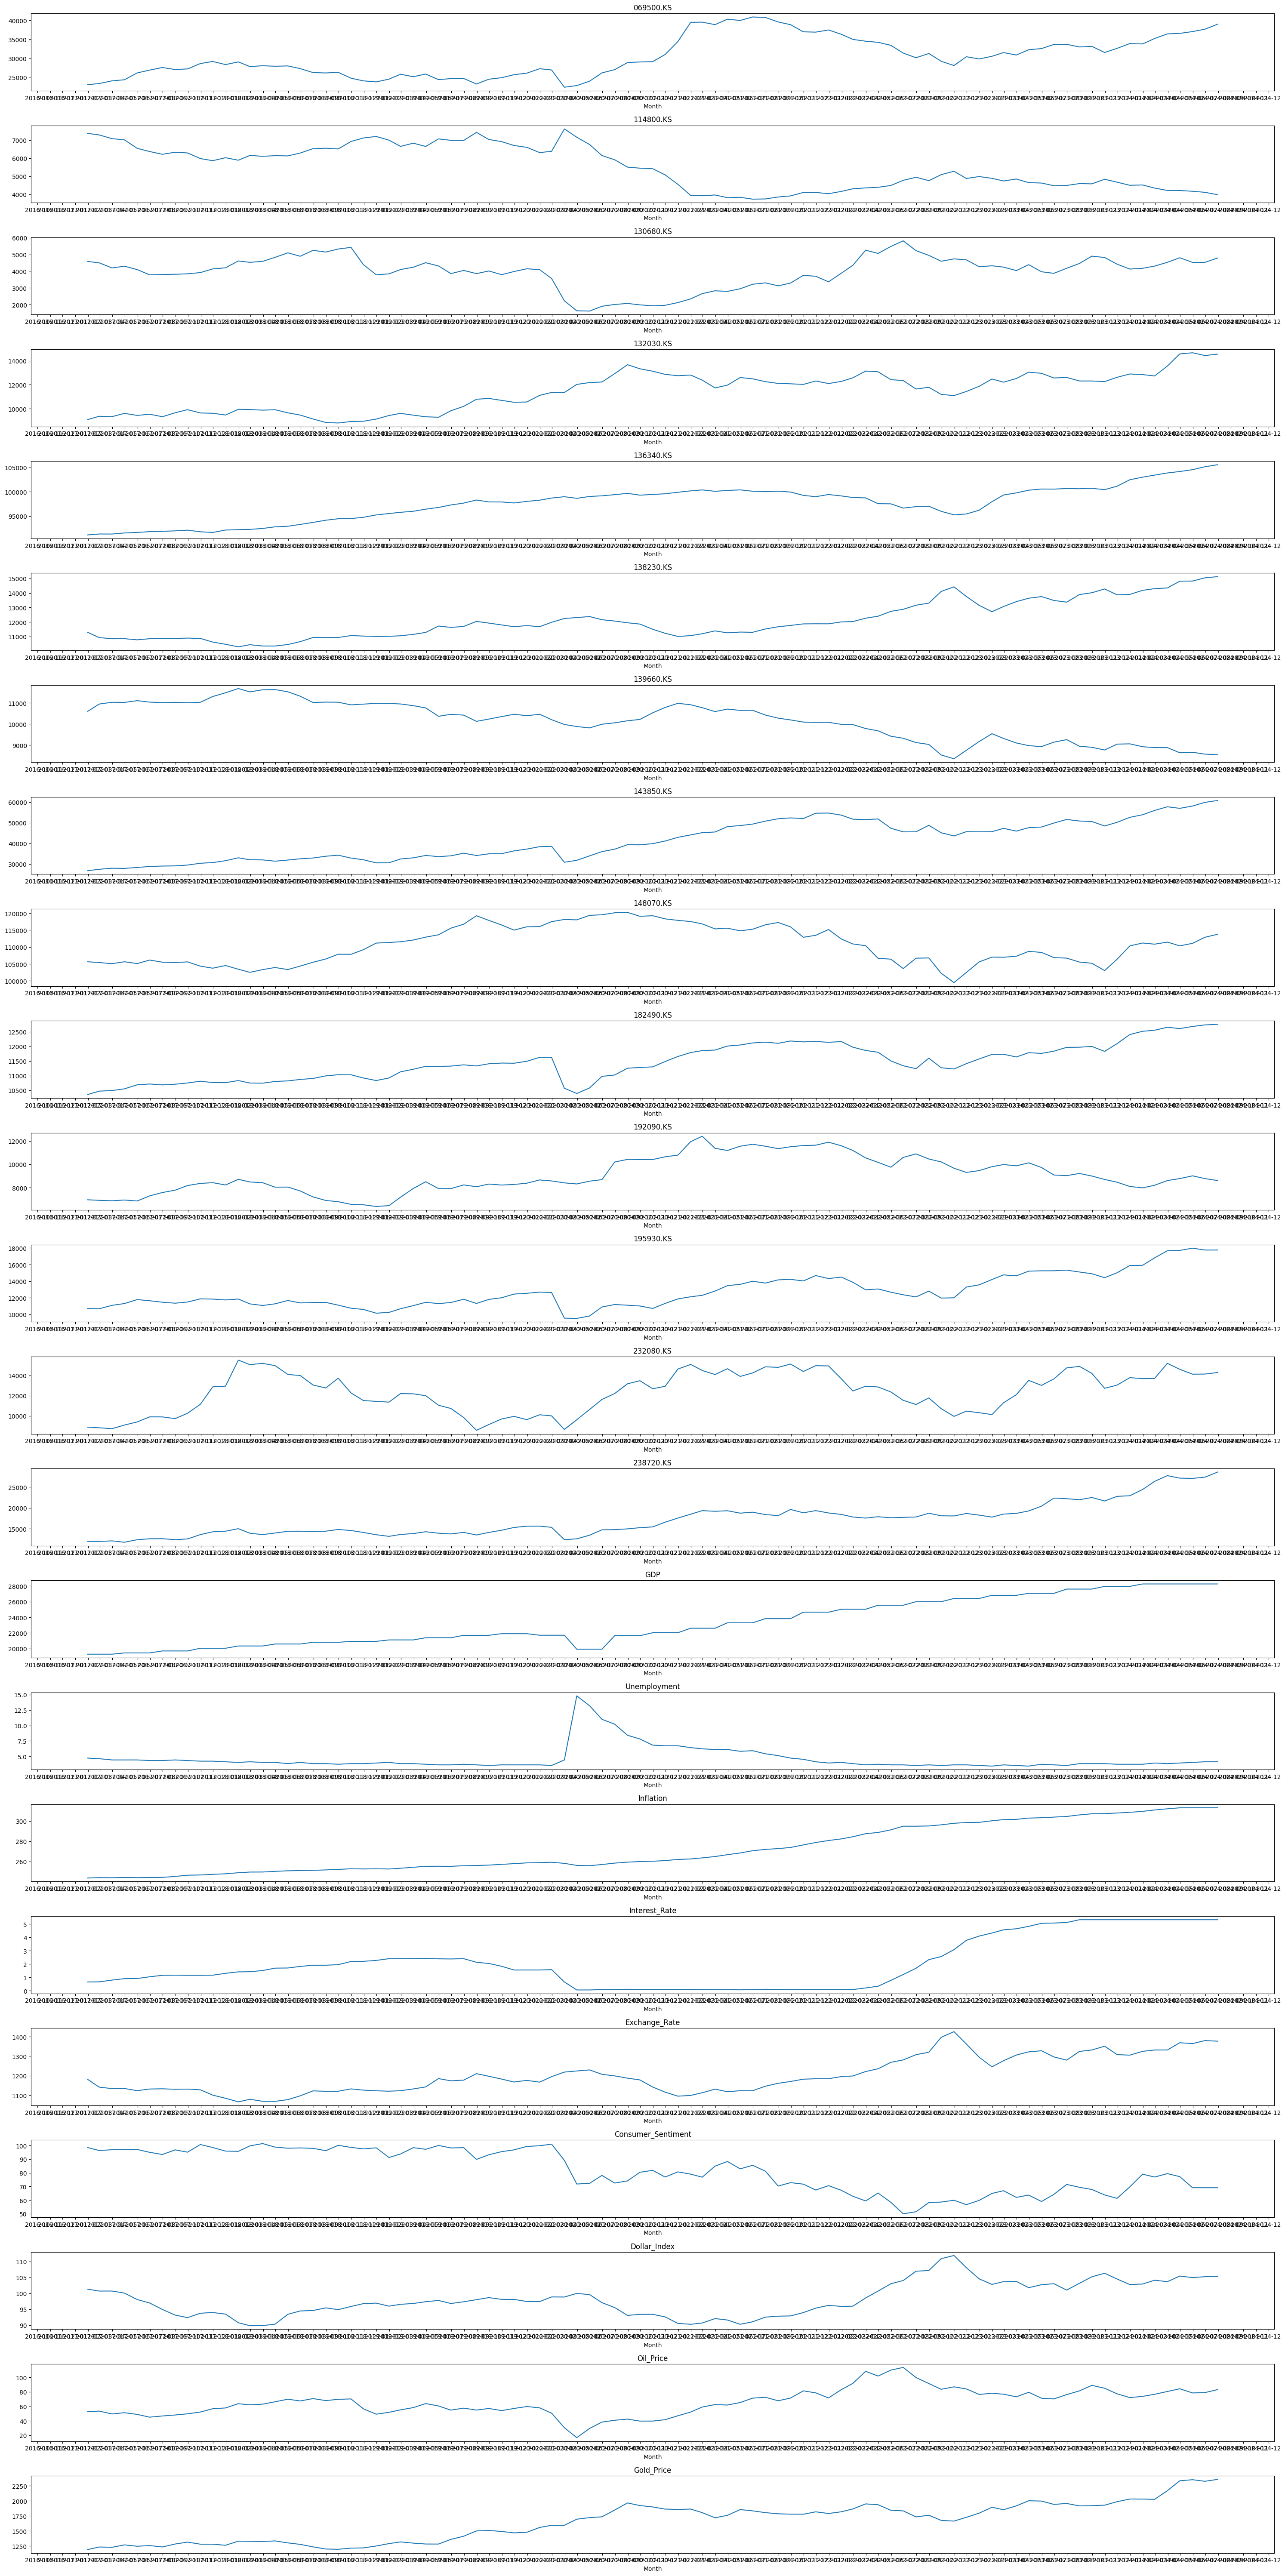

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

# 데이터 시각화
def plot_time_series_monthly(data, columns):
    data_monthly = data.resample('M').mean()
    plt.figure(figsize=(30, 60))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 1, i)
        plt.plot(data_monthly.index, data_monthly[col])
        plt.title(col)
        plt.xlabel('Month')
        plt.xlabel.rotate = 90
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

# 데이터 시각화
plot_time_series_monthly(data, data.columns)

In [5]:
# ADF 테스트 함수
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')
    print()

# 차분 후 ADF 테스트 함수
def difference_adf_test(series, title=''):
    diff_series = series.diff().dropna()
    adf_test(diff_series, title + ' (1st Difference)')
    return diff_series

# 원 데이터 ADF 테스트
adf_results = {}
for column in data.columns:
    adf_results[column] = adf_test(data[column], column)

ADF Test: 069500.KS
ADF Statistic: -1.1212456364330978
p-value: 0.7065254595678532
Critical Values 1%: -3.433976034843506
Critical Values 5%: -2.8631416925158244
Critical Values 10%: -2.5676226884667694

ADF Test: 114800.KS
ADF Statistic: -1.3807987539846172
p-value: 0.5914460388059715
Critical Values 1%: -3.433968010099092
Critical Values 5%: -2.8631381499714745
Critical Values 10%: -2.567620802173316

ADF Test: 130680.KS
ADF Statistic: -1.8723669453748828
p-value: 0.34517011492536176
Critical Values 1%: -3.433978046594855
Critical Values 5%: -2.8631425806072164
Critical Values 10%: -2.567623161347749

ADF Test: 132030.KS
ADF Statistic: -1.0884169511936184
p-value: 0.7196689175647127
Critical Values 1%: -3.4339540519343137
Critical Values 5%: -2.863131988080628
Critical Values 10%: -2.5676175211639354

ADF Test: 136340.KS
ADF Statistic: 0.03169841827509402
p-value: 0.9610763258530545
Critical Values 1%: -3.433972018026501
Critical Values 5%: -2.8631399192826676
Critical Values 10%: -2

ADF 테스트는 주어진 시계열 데이터가 정상성(stationarity)을 가지는지 여부를 판단하는 통계 테스트
* 해석
    * ADF 통계량 -> 음수일수록 데이터 정상성을 가지는 것에 대한 증거 강해짐
    * p-value ->  p-값이 0.05 이하이면 귀무가설(데이터가 비정상성이다)을 기각
    * Critical values 유의 수준 -> 이 값들은 다양한 유의 수준(1%, 5%, 10%)에서의 임계값입니다. ADF 통계량이 이 임계값보다 낮으면 귀무가설을 기각

* 결과
    * ETF 데이터와 거시경제 지표
    * 전부 비정상성을 띄고 있다 따라서 차분을 통해 정상성을 맞추고자 한다.

In [6]:
# 차분 후 ADF 테스트 함수
def difference_adf_test(series, title=''):
    diff_series = series.diff().dropna()
    adf_test(diff_series, title + ' (1st Difference)')
    return diff_series

# 차분 후 ADF 테스트
diff_data = pd.DataFrame()
for column in data.columns:
    diff_data[column] = difference_adf_test(data[column], column)

ADF Test: 069500.KS (1st Difference)
ADF Statistic: -13.087359855363042
p-value: 1.8181535062895446e-24
Critical Values 1%: -3.433976034843506
Critical Values 5%: -2.8631416925158244
Critical Values 10%: -2.5676226884667694

ADF Test: 114800.KS (1st Difference)
ADF Statistic: -9.689598066454982
p-value: 1.1459033403859125e-16
Critical Values 1%: -3.434006447337251
Critical Values 5%: -2.863155118104396
Critical Values 10%: -2.567629837184558

ADF Test: 130680.KS (1st Difference)
ADF Statistic: -12.004205917229152
p-value: 3.292776284087778e-22
Critical Values 1%: -3.433978046594855
Critical Values 5%: -2.8631425806072164
Critical Values 10%: -2.567623161347749

ADF Test: 132030.KS (1st Difference)
ADF Statistic: -43.26404835451356
p-value: 0.0
Critical Values 1%: -3.4339560393603112
Critical Values 5%: -2.8631328654399884
Critical Values 10%: -2.5676179883293875

ADF Test: 136340.KS (1st Difference)
ADF Statistic: -11.123716732262363
p-value: 3.4152825726651417e-20
Critical Values 1%: 

In [7]:
 # 차분된 데이터 시각화
plot_time_series_monthly(diff_data, diff_data.columns)

Output hidden; open in https://colab.research.google.com to view.

## 피드백
* 거시경제 + 장 흐름을 반영할 수 있는 지표들 (달러 인덱스, 석유, 수출수익 지수 ??, 원자재 가격 ...  ...)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1818 entries, 2017-01-02 to 2024-07-08
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   069500.KS           1818 non-null   float64
 1   114800.KS           1818 non-null   float64
 2   130680.KS           1818 non-null   float64
 3   132030.KS           1818 non-null   float64
 4   136340.KS           1818 non-null   float64
 5   138230.KS           1818 non-null   float64
 6   139660.KS           1818 non-null   float64
 7   143850.KS           1818 non-null   float64
 8   148070.KS           1818 non-null   float64
 9   182490.KS           1818 non-null   float64
 10  192090.KS           1818 non-null   float64
 11  195930.KS           1818 non-null   float64
 12  232080.KS           1818 non-null   float64
 13  238720.KS           1818 non-null   float64
 14  GDP                 1818 non-null   float64
 15  Unemployment        1818 non-null   f

## 2. 데이터 전처리

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 데이터 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = data[macro_data.columns]  # 거시경제적 지표
y = data[tickers]  # 티커의 투자 비율

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 시계열 데이터 셋 만들기
def create_sequences(X, y, time_steps=8):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# 데이터셋 분할을 위해 인덱스 생성
index_dates = data.index[time_steps:]  # 시계열 데이터를 생성한 후의 인덱스

# 연도별 데이터 분할
train_indices = index_dates.year < 2022
val_indices = (index_dates.year >= 2022) & (index_dates.year < 2024)
test_indices = index_dates.year >= 2024

# 훈련 데이터셋
X_train = X_seq[train_indices]
y_train = y_seq[train_indices]

# 검증 데이터셋
X_val = X_seq[val_indices]
y_val = y_seq[val_indices]

# 테스트 데이터셋
X_test = X_seq[test_indices]
y_test = y_seq[test_indices]

# 확인
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


X_train shape: (1196, 24, 9), y_train shape: (1196, 14)
X_val shape: (472, 24, 9), y_val shape: (472, 14)
X_test shape: (126, 24, 9), y_test shape: (126, 14)


## 3. 모델 설계 학습

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Flatten, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dropout(mlp_dropout)(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu", kernel_regularizer='l2')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(len(tickers), activation="linear")(x)
    return Model(inputs, outputs)

input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,  # Increased head size
    num_heads=8,  # Increased number of heads
    ff_dim=128,  # Increased feed-forward network dimension
    num_transformer_blocks=6,  # Increased number of transformer blocks
    mlp_units=[256, 128],  # Added another MLP layer and increased dimensions
    mlp_dropout=0.4,
    dropout=0.3,  # Increased dropout
)

Epoch 1/500
38/38 [==============================] - 28s 65ms/step - loss: 4.9366 - val_loss: 6.5712 - lr: 0.0010
Epoch 2/500
38/38 [==============================] - 2s 50ms/step - loss: 3.9672 - val_loss: 4.2892 - lr: 0.0010
Epoch 3/500
38/38 [==============================] - 1s 36ms/step - loss: 3.3524 - val_loss: 3.5015 - lr: 0.0010
Epoch 4/500
38/38 [==============================] - 1s 36ms/step - loss: 2.6906 - val_loss: 2.6440 - lr: 0.0010
Epoch 5/500
38/38 [==============================] - 1s 36ms/step - loss: 2.2818 - val_loss: 2.2844 - lr: 0.0010
Epoch 6/500
38/38 [==============================] - 1s 35ms/step - loss: 1.7715 - val_loss: 2.3809 - lr: 0.0010
Epoch 7/500
38/38 [==============================] - 1s 35ms/step - loss: 1.6122 - val_loss: 1.9166 - lr: 0.0010
Epoch 8/500
38/38 [==============================] - 1s 36ms/step - loss: 1.4474 - val_loss: 1.4910 - lr: 0.0010
Epoch 9/500
38/38 [==============================] - 1s 36ms/step - loss: 1.1415 - val_loss: 1.

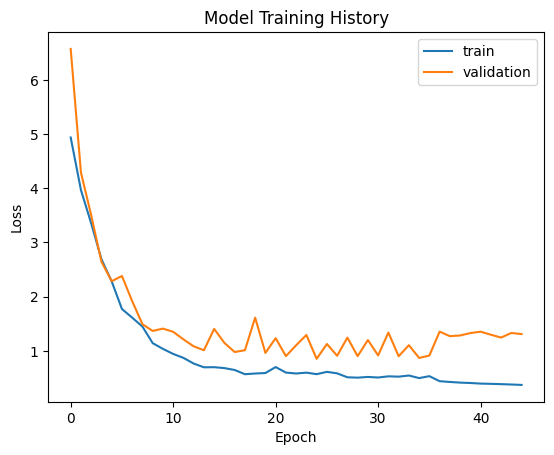

In [11]:
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Adam optimizer with learning rate warm-up
optimizer = Adam(learning_rate=1e-3)

# Model compile
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Model training
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,  # Increased batch size
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Training history visualization
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

Epoch 1/500
68/68 [==============================] - 9s 27ms/step - loss: 0.9633 - val_loss: 0.6437
Epoch 2/500
68/68 [==============================] - 1s 11ms/step - loss: 0.9446 - val_loss: 0.6278
Epoch 3/500
68/68 [==============================] - 1s 11ms/step - loss: 0.9246 - val_loss: 0.6133
Epoch 4/500
68/68 [==============================] - 1s 11ms/step - loss: 0.9057 - val_loss: 0.5999
Epoch 5/500
68/68 [==============================] - 1s 11ms/step - loss: 0.8891 - val_loss: 0.5876
Epoch 6/500
68/68 [==============================] - 1s 11ms/step - loss: 0.8685 - val_loss: 0.5758
Epoch 7/500
68/68 [==============================] - 1s 11ms/step - loss: 0.8570 - val_loss: 0.5641
Epoch 8/500
68/68 [==============================] - 1s 11ms/step - loss: 0.8406 - val_loss: 0.5532
Epoch 9/500
68/68 [==============================] - 1s 14ms/step - loss: 0.8207 - val_loss: 0.5428
Epoch 10/500
68/68 [==============================] - 1s 15ms/step - loss: 0.8080 - val_loss: 0.5327

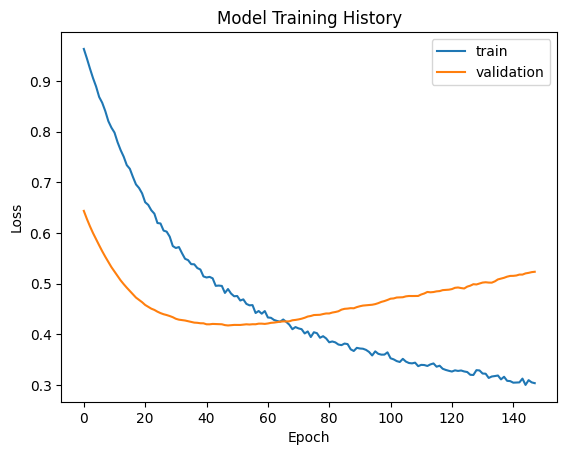

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt

# # GRU 모델 설계
# model = Sequential()
# model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.4))
# model.add(GRU(64, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(GRU(64, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(GRU(32, return_sequences=False))
# model.add(Dropout(0.4))
# model.add(Dense(len(tickers), activation='linear'))

# # 학습률 설정
# learning_rate = 0.00001

# # Adam 옵티마이저 생성
# optimizer = Adam(learning_rate=learning_rate)

# # 모델 컴파일
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # 조기 종료 콜백 설정
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# # 모델 학습
# history = model.fit(
#     X_train, y_train,
#     epochs=500,
#     batch_size=16,
#     validation_data=(X_val, y_val),
#     shuffle=False,
#     callbacks=[early_stopping]
# )

# # 학습 결과 시각화
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Model Training History')
# plt.show()

## 4. 모델 예측
* input -> 거시경제 지표
* output -> 각 ETF 투자 비율

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming X_test and y_test are already prepared and scaled
# Let's define the scaler for the target values if not defined
scaler_y = StandardScaler()

# Fitting the scaler on the training target values
scaler_y.fit(y_train)

# Model prediction
y_pred = model.predict(X_test)

# Check the shape of data
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_pred shape: {y_pred.shape}')

# Inverse scaling of predictions and actual values
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

# Bounds for each ticker
bounds = {
    '069500.KS': (0, 40),
    '232080.KS': (0, 20),
    '143850.KS': (0, 20),
    '195930.KS': (0, 20),
    '238720.KS': (0, 20),
    '192090.KS': (0, 20),
    '148070.KS': (0, 50),
    '136340.KS': (0, 40),
    '182490.KS': (5, 40),
    '132030.KS': (0, 15),
    '130680.KS': (0, 15),
    '114800.KS': (0, 20),
    '138230.KS': (0, 20),
    '139660.KS': (0, 20)
}

# Apply constraints function
def apply_constraints(predictions, bounds):
    constrained_predictions = np.zeros_like(predictions)
    for i, col in enumerate(bounds.keys()):
        min_bound, max_bound = bounds[col]
        constrained_predictions[:, i] = np.clip(predictions[:, i], min_bound, max_bound)
    return constrained_predictions

# Normalize predictions to sum up to 99%
def normalize_to_99(predictions):
    normalized_predictions = np.zeros_like(predictions)
    for i in range(predictions.shape[0]):
        total = np.sum(predictions[i])
        if total > 0:
            normalized_predictions[i] = (predictions[i] / total) * 99
    return normalized_predictions

# Apply constraints
y_pred_constrained = apply_constraints(y_pred_unscaled, bounds)

# Normalize predictions
y_pred_normalized = normalize_to_99(y_pred_constrained)

# Create a DataFrame for the results
results_constrained = pd.DataFrame(y_pred_normalized, columns=tickers)
results_constrained.index = X_test.index  # 인덱스 설정 추가

# Save results to a CSV file
results_constrained.to_csv('investment_predictions_constrained_transformer_0708.csv', index=True)  # 파일 이름 변경

print(results_constrained.head())


4/4 [==============================] - 0s 23ms/step
X_test shape: (125, 24, 9)
y_test shape: (125, 14)
y_pred shape: (125, 14)


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
print(results_constrained.tail())

            069500.KS  232080.KS  143850.KS  195930.KS  238720.KS  192090.KS  \
2024-07-01   6.638479   6.532565        0.0        0.0        0.0   9.829435   
2024-07-02   6.627551   6.524091        0.0        0.0        0.0   9.818492   
2024-07-03   6.608127   6.509076        0.0        0.0        0.0   9.799020   
2024-07-04   6.604037   6.505884        0.0        0.0        0.0   9.794950   
2024-07-05   6.600653   6.503315        0.0        0.0        0.0   9.791538   

            148070.KS  136340.KS  182490.KS  132030.KS  130680.KS  114800.KS  \
2024-07-01  11.825002   1.500379  54.567600   0.703402        0.0        0.0   
2024-07-02  11.823492   1.493524  54.607956   0.697017        0.0        0.0   
2024-07-03  11.821037   1.481543  54.679138   0.685881        0.0        0.0   
2024-07-04  11.820459   1.478979  54.694248   0.683469        0.0        0.0   
2024-07-05  11.819951   1.476842  54.706802   0.681443        0.0        0.0   

            138230.KS  139660.KS  
202

In [ ]:
import pandas as pd

# 파일 경로 설정
file_path = 'investment_predictions_constrained.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path, index_col=0)

# ETF 가격 데이터
print(data.head())

# 각 날짜에 대해 포트폴리오의 총 가치 계산 (주식 수를 1로 가정)
portfolio_values = data.sum(axis=1)

# 투자 비율 계산 (각 ETF 가격을 포트폴리오 총 가치로 나눔)
investment_ratios = data.div(portfolio_values, axis=0)

# 결과 확인
print(investment_ratios.head())

# 백분율로 변환하여 저장
investment_ratios_percentage = investment_ratios * 100
investment_ratios_percentage.to_csv('/content/drive/MyDrive/열정페이 스터디/24-1_finance/investment_ratios_percentage_0708.csv')

print("CSV 파일로 저장 완료: /content/drive/MyDrive/열정페이 스터디/24-1_finance/investment_ratios_percentage_0708.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'investment_predictions_constrained.csv'

### 하이퍼파라미터 튜닝 part
0. learning_rate
1. 거시경제 지표 몇개년 사용할지
2. epoch, batch_size
3. dropout 비율
4. normalizaition
5. 초기화 방식
6. 시계열 길이 -> 더 긴 시계열 패턴

In [ ]:
print(investment_ratios.tail(10))

            069500.KS  232080.KS  143850.KS  195930.KS  271050.KS  192090.KS
2024-06-11   0.271868   0.098207   0.378640   0.112899   0.060522   0.077864
2024-06-12   0.271747   0.098141   0.378681   0.112964   0.060639   0.077829
2024-06-13   0.271689   0.098083   0.378785   0.113013   0.060637   0.077793
2024-06-14   0.271734   0.098062   0.378980   0.113020   0.060449   0.077755
2024-06-17   0.271694   0.097999   0.379387   0.113065   0.060133   0.077723
2024-06-18   0.271718   0.097957   0.379809   0.113103   0.059726   0.077688
2024-06-19   0.271783   0.097929   0.380145   0.113125   0.059368   0.077650
2024-06-20   0.271859   0.097914   0.380511   0.113105   0.058971   0.077640
2024-06-21   0.271917   0.097885   0.380871   0.113059   0.058611   0.077657
2024-06-24   0.271927   0.097850   0.381243   0.113047   0.058270   0.077662


1. 주간 데이터로 사용할 때
* 데이터셋이 너무 적어서 과적합 일어남
* dropout, earlystop, shuffle, batch_size, learning_rate 조정
-> 제대로 학습 이뤄지지 않음 + output에 대한 타당성 없음

2. 주간 -> 일간 데이터 사용
* 데이터셋을 더 늘리기 위해서 주간에서 일간으로 바꿈
* 각각 하이퍼파라미터 조정을 통해서 loss 줄이기 위한 과정 진행
* val_loss 0.4 이하로 떨어지지 않음


### 수익률을 통한 평가

수익률은 ((오늘 종가 - 어제 종가) / 어제 종가) * 100

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 예측된 주가 데이터 (y_pred_unscaled)와 실제 주가 데이터 (y_test_unscaled) 사용
# y_pred_unscaled와 y_test_unscaled는 모델 예측 값과 실제 값으로, 역정규화된 값이어야 합니다.

# 수익률 계산 함수
def calculate_returns(prices):
    returns = (prices[1:] - prices[:-1]) / prices[:-1]
    return returns

# 실제 수익률 계산
actual_returns = pd.DataFrame(y_test_unscaled, columns=tickers).pct_change().dropna()

# 예측 수익률 계산
predicted_returns = pd.DataFrame(y_pred_unscaled, columns=tickers).pct_change().dropna()

# 성능 평가 지표 계산 함수
def evaluate_performance(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# 각 티커별로 성능 평가
performance_metrics = {}
for ticker in tickers:
    actual = actual_returns[ticker].values
    predicted = predicted_returns[ticker].values
    mae, mse, rmse = evaluate_performance(actual, predicted)
    performance_metrics[ticker] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# 성능 평가 결과 출력
performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

# 평균 성능 평가 결과 출력
average_mae = performance_df['MAE'].mean()
average_mse = performance_df['MSE'].mean()
average_rmse = performance_df['RMSE'].mean()

print(f'Average MAE: {average_mae}')
print(f'Average MSE: {average_mse}')
print(f'Average RMSE: {average_rmse}')


                MAE           MSE      RMSE
069500.KS  0.008812  1.234562e-04  0.011111
232080.KS  0.009902  1.694998e-04  0.013019
143850.KS  0.005738  5.489998e-05  0.007409
195930.KS  0.007425  7.992215e-05  0.008940
271050.KS  0.012318  2.466926e-04  0.015706
192090.KS  0.007561  9.655919e-05  0.009826
148070.KS  0.002724  1.116535e-05  0.003341
136340.KS  0.000498  3.865274e-07  0.000622
182490.KS  0.002613  1.119368e-05  0.003346
132030.KS  0.006969  9.414940e-05  0.009703
130680.KS  0.011541  1.931542e-04  0.013898
114800.KS  0.009397  1.388672e-04  0.011784
138230.KS  0.003609  2.214382e-05  0.004706
139660.KS  0.003352  2.005998e-05  0.004479
Average MAE: 0.0066041087145898205
Average MSE: 9.015358028235654e-05
Average RMSE: 0.008420803235189544


### 결과 바탕으로 백테스팅 진행

In [ ]:
import pandas as pd

# 예측된 투자 비중 데이터 로드
results_constrained = pd.read_csv('investment_predictions_constrained_transformer.csv', index_col=0)

# 데이터 확인
print(results_constrained.head())

            069500.KS  232080.KS  143850.KS  195930.KS  271050.KS  192090.KS  \
2024-01-02       12.5       12.5       6.25       6.25       6.25       6.25   
2024-01-03       12.5       12.5       6.25       6.25       6.25       6.25   
2024-01-04       12.5       12.5       6.25       6.25       6.25       6.25   
2024-01-05       12.5       12.5       6.25       6.25       6.25       6.25   
2024-01-08       12.5       12.5       6.25       6.25       6.25       6.25   

            148070.KS  136340.KS  182490.KS  132030.KS  130680.KS  114800.KS  \
2024-01-02       6.25       6.25       6.25       6.25       6.25       6.25   
2024-01-03       6.25       6.25       6.25       6.25       6.25       6.25   
2024-01-04       6.25       6.25       6.25       6.25       6.25       6.25   
2024-01-05       6.25       6.25       6.25       6.25       6.25       6.25   
2024-01-08       6.25       6.25       6.25       6.25       6.25       6.25   

            138230.KS  139660.KS  
202

In [ ]:
import yfinance as yf

# ETF 티커 목록
tickers = ['069500.KS', '232080.KS', '143850.KS', '195930.KS', '271050.KS', '192090.KS',
           '148070.KS', '136340.KS', '182490.KS', '132030.KS', '130680.KS', '114800.KS',
           '138230.KS', '139660.KS']

# 가격 데이터를 가져올 기간 설정
start_date = '2024-06-01'
end_date = '2024-06-30'

# yfinance를 사용하여 ETF 가격 데이터 가져오기
etf_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 데이터 확인
print(etf_data.head())


[*********************100%%**********************]  14 of 14 completed


Ticker      069500.KS  114800.KS  130680.KS  132030.KS      136340.KS  \
Date                                                                    
2024-06-03    36660.0     4210.0     4425.0    14395.0  104717.992188   
2024-06-04    36390.0     4240.0     4260.0    14600.0  104792.601562   
2024-06-05    36755.0     4200.0     4230.0    14490.0  104887.109375   
2024-06-07    37240.0     4150.0     4340.0    14745.0  104991.562500   
2024-06-10    36915.0     4190.0     4355.0    14230.0  104867.210938   

Ticker      138230.KS  139660.KS  143850.KS  148070.KS  182490.KS  192090.KS  \
Date                                                                           
2024-06-03    14955.0     8590.0    58545.0   111245.0    12655.0     8905.0   
2024-06-04    14985.0     8590.0    58420.0   111850.0    12685.0     8930.0   
2024-06-05    14940.0     8610.0    58605.0   112200.0    12690.0     8890.0   
2024-06-07    14850.0     8660.0    59275.0   112610.0    12720.0     8800.0   
2024-06-

            Portfolio Value
Date                       
2024-06-03              NaN
2024-06-04              NaN
2024-06-05              NaN
2024-06-07              NaN
2024-06-10              NaN
2024-06-11              NaN
2024-06-12              NaN
2024-06-13              NaN
2024-06-14              NaN
2024-06-17              NaN
2024-06-18              NaN
2024-06-19              NaN
2024-06-20              NaN
2024-06-21              NaN
2024-06-24              NaN
2024-06-25              NaN
2024-06-26              NaN
2024-06-27              NaN
2024-06-28              NaN
            Portfolio Value  Daily Return
Date                                     
2024-06-03              NaN           NaN
2024-06-04              NaN           NaN
2024-06-05              NaN           NaN
2024-06-07              NaN           NaN
2024-06-10              NaN           NaN
2024-06-11              NaN           NaN
2024-06-12              NaN           NaN
2024-06-13              NaN       

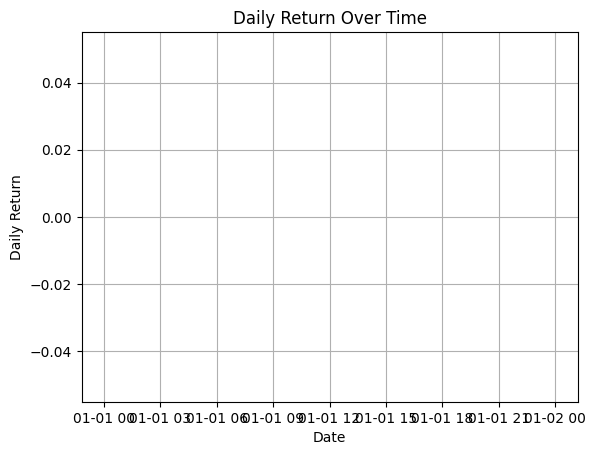

In [ ]:
def backtest_portfolio(allocations, price_data, initial_value=10000000000):
    """
    백테스팅 함수
    :param allocations: 예측된 투자 비중 데이터프레임
    :param price_data: 실제 ETF 가격 데이터프레임
    :param initial_value: 초기 포트폴리오 가치
    :return: 포트폴리오 가치 시계열 데이터프레임
    """
    # 포트폴리오 가치 시계열 데이터프레임 초기화
    portfolio_values = pd.DataFrame(index=price_data.index)
    portfolio_values['Portfolio Value'] = np.nan

    # 각 날짜별 포트폴리오 가치 계산
    for i, date in enumerate(price_data.index):
        if date in allocations.index:
            # 해당 날짜의 투자 비중
            weights = allocations.loc[date].values

            # 해당 날짜의 각 ETF의 가치
            etf_values = price_data.loc[date].values

            # 수정 부분: 초기 포트폴리오에서 각 ETF에 투자된 금액 계산
            if i == 0:
                initial_investment = initial_value * weights
                initial_prices = etf_values
                shares = initial_investment / initial_prices
                portfolio_value = initial_value
            else:
                # 수정 부분: 현재 날짜의 각 ETF의 가치
                current_values = shares * etf_values
                portfolio_value = current_values.sum()

            # 포트폴리오 가치 저장
            portfolio_values.loc[date, 'Portfolio Value'] = portfolio_value

    return portfolio_values

# 백테스팅 수행
portfolio_values = backtest_portfolio(results_constrained, etf_data)

# 백테스팅 결과 확인
print(portfolio_values)

# 수익률 계산
portfolio_values['Daily Return'] = portfolio_values['Portfolio Value'].pct_change()

# 수익률 확인
print(portfolio_values)

# 수익률 시각화
plt.plot(portfolio_values.index, portfolio_values['Daily Return'])
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Return Over Time')
plt.grid(True)
plt.show()